# Part 1: Sherlock Holmes Next-Word Predictor (Corrected & Ordered)

This notebook contains all the steps to preprocess the data, build and train the model, and deploy the Streamlit app. The cells are in the correct order. Just run them from top to bottom.

## Step 1: Imports and Setup

This first cell imports all necessary libraries and sets up the device (CPU or GPU).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import os
import requests
import re
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset, random_split
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Step 2: Data Preprocessing (Part 1.1)

This cell will:
1.  Download the Sherlock Holmes text.
2.  Clean the text.
3.  Build the vocabulary (`stoi` and `itos`).
4.  Report the vocabulary size and most/least frequent words.
5.  Save the vocabulary to `vocab.json` for our app.

In [3]:
import requests
import re
from collections import Counter
import json

print("--- Step 2: Downloading and Preprocessing Data ---")

# --- FIX: Define the URL string first ---
url = "https://www.gutenberg.org/files/1661/1661-0.txt"
text = "" # Initialize variable

try:
    # --- FIX: Use the 'url' variable ---
    full_text = requests.get(url).text
    print(f"Successfully downloaded {len(full_text)} characters.")
except Exception as e:
    print(f"ERROR: Failed to download text from {url}")
    raise e

# --- Robust Text Extraction ---
start_marker = "THE ADVENTURES OF SHERLOCK HOLMES"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK"

# --- CRITICAL FIX: Convert full text to upper for a case-insensitive search ---
full_text_upper = full_text.upper()
start_index = full_text_upper.find(start_marker)
end_index = full_text_upper.find(end_marker)
# --- End of Fix ---

print(f"Start marker found at index: {start_index}")
print(f"End marker found at index: {end_index}")

if start_index == -1 or end_index == -1:
    print("ERROR: Could not find start or end markers in the text. Stopping.")
    # Printing a snippet of the text to help debug if it fails again
    print("\n--- Start of Text Snippet ---")
    print(full_text[:500])
    print("--- End of Text Snippet ---")
    raise ValueError("Could not parse book text. Markers not found.")

# We use the indices to slice the ORIGINAL text
text = full_text[start_index:end_index]
print(f"Extracted {len(text)} characters of book text.")

# Clean, split, and build vocab
text = text.lower()
text = re.sub(r'[^a-z. ]', '', text) # r'...' is a "raw string"
words = text.split()

if len(words) == 0:
    print("ERROR: No words found after cleaning text. Stopping.")
    raise ValueError("Text cleaning resulted in an empty word list.")

vocab = sorted(list(set(words)))
vocab_size = len(vocab)
print(f"\nData ready. Final Vocab size: {vocab_size}")

stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for i,s in enumerate(vocab)}

# Report most/least frequent words (for your assignment)
word_counts = Counter(words)
print("\n--- Assignment 1.1 Report ---")
print(f"Vocabulary Size: {vocab_size}")
print("\n10 Most Frequent Words:")
print(word_counts.most_common(10))
print("\n10 Least Frequent Words:")
print(word_counts.most_common()[-10:])

# Save the new vocab file for the app
vocab_data = {
    'stoi': stoi,
    'itos': itos,
    'vocab_size': len(stoi)
}
with open('sherlock_vocab.json', 'w') as f:  # <-- Use this new name
    json.dump(vocab_data, f)
print("\n'sherlock_vocab.json' saved successfully.")

--- Step 2: Downloading and Preprocessing Data ---
Successfully downloaded 593731 characters.
Start marker found at index: 32
End marker found at index: 575062
Extracted 575030 characters of book text.

Data ready. Final Vocab size: 16266

--- Assignment 1.1 Report ---
Vocabulary Size: 16266

10 Most Frequent Words:
[('the', 4645), ('and', 2513), ('i', 2421), ('to', 2361), ('of', 2353), ('a', 2294), ('in', 1555), ('that', 1480), ('it', 1293), ('was', 1214)]

10 Least Frequent Words:
[('ofrucastles', 1), ('mr.fowler', 1), ('insouthampton', 1), ('agovernment', 1), ('mauritius.', 1), ('violethunter', 1), ('manifested', 1), ('nofurther', 1), ('school', 1), ('atwalsall', 1)]

'sherlock_vocab.json' saved successfully.


## Step 3: Create Training Data (Part 1.1 continued)

This cell creates the `(X, y)` pairs for training.

In [4]:
# print("--- Step 3: Creating Training Data ---")
# BLOCK_SIZE = 8 # This is the context size (how many words to predict the next)

# X, y = [], []
# for i in range(len(words) - BLOCK_SIZE):
#     context = [stoi[w] for w in words[i:i+BLOCK_SIZE]]
#     target = stoi[words[i+BLOCK_SIZE]]
#     X.append(context)
#     y.append(target)

# X_train = torch.tensor(X).to(device)
# y_train = torch.tensor(y).to(device)

# print(f"Created {len(X_train)} training examples.")
# print(f"X_train shape: {X_train.shape}")
# print(f"y_train shape: {y_train.shape}")

# --- Step 4: Build the Dataset ---

# --- Set Hyperparameters ---
BLOCK_SIZE = 8  # This is your context window size
# ---------------------------

# This function creates the (X, y) pairs
def build_dataset(words, block_size, stoi):
    X, y = [], []
    unk_idx = stoi.get('<UNK>', 0) # Use 0 or a known <UNK> index
    
    for i in range(len(words) - block_size):
        context = words[i : i + block_size]
        target = words[i + block_size]
        
        context_ix = [stoi.get(w, unk_idx) for w in context]
        target_ix = stoi.get(target, unk_idx)
        
        X.append(context_ix)
        y.append(target_ix)
        
    X = torch.tensor(X, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)
    return X, y

# --- Create X and y ---
print("Building dataset...")
# Make sure 'words' and 'stoi' are defined from the cell above
X, y = build_dataset(words, BLOCK_SIZE, stoi)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# --- Create the Dataset and Split ---
dataset = TensorDataset(X, y)
val_size = int(len(dataset) * 0.1) # 10% for validation
train_size = len(dataset) - val_size

# --- This is the part that fixes your error ---
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# ---------------------------------------------

print(f"Total examples: {len(dataset)}")
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")

Building dataset...
X shape: torch.Size([95301, 8])
y shape: torch.Size([95301])
Total examples: 95301
Training examples: 85771
Validation examples: 9530


## Step 4: Model Definition (Part 1.2)

This is the simple MLP model (`NextWordPredictor`) that matches your notebook.

In [5]:
# # class NextWordPredictor(nn.Module):
# #     def __init__(self, vocab_size, emb_dim, block_size, hidden_size):
# #         super().__init__()
# #         self.block_size = block_size
# #         self.embedding = nn.Embedding(vocab_size, emb_dim)
# #         self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
# #         self.lin2 = nn.Linear(hidden_size, hidden_size)
# #         self.lin3 = nn.Linear(hidden_size, hidden_size)
# #         self.lin4 = nn.Linear(hidden_size, hidden_size)
# #         self.lin_out = nn.Linear(hidden_size, vocab_size)

# #     def forward(self, idx, targets=None):
# #         B, T = idx.shape
# #         x = self.embedding(idx) # (B, T, emb_dim)
# #         x = x.view(B, T * self.embedding.embedding_dim) # (B, T*emb_dim)
# #         # x = torch.tanh(self.lin1(x))
# #         # x = torch.tanh(self.lin2(x))
# #         # x = torch.tanh(self.lin3(x))
# #         # x = torch.tanh(self.lin4(x))
# #         # logits = self.lin_out(x) # (B, vocab_size)

# #         # ... embedding and view ...
# #         x = torch.tanh(self.lin1(x))
# #         x = torch.tanh(self.lin2(x))
# #         x = torch.tanh(self.lin3(x))
# #         x = torch.tanh(self.lin4(x))
# #         x = torch.tanh(self.lin5(x)) # Add new layer
# #         x = torch.tanh(self.lin6(x)) # Add new layer
# #         logits = self.lin_out(x)
# #     # ... rest of forward ...

# #         loss = None
# #         if targets is not None:
# #             loss = F.cross_entropy(logits, targets)
# #         return logits, loss

# #     def generate(self, idx, max_new_tokens):
# #         self.eval()
# #         for _ in range(max_new_tokens):
# #             idx = idx.to(device) # Ensure tensor is on the correct device
# #             idx_cond = idx[:, -self.block_size:]
# #             logits, loss = self(idx_cond)
# #             probs = F.softmax(logits, dim=-1)
# #             idx_next = torch.multinomial(probs, num_samples=1)
# #             idx = torch.cat((idx, idx_next), dim=1).long() # Force to .long() to prevent float conversion
# #         return idx[:, -max_new_tokens:]

# # print("Model class 'NextWordPredictor' defined.")
# import torch.nn as nn
# import torch.nn.functional as F

# class NextWordPredictor(nn.Module):
#     def __init__(self, vocab_size, emb_dim, block_size, hidden_size):
#         super().__init__()
#         self.block_size = block_size
#         self.embedding = nn.Embedding(vocab_size, emb_dim)
#         # Define ALL the layers here
#         self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
#         self.lin2 = nn.Linear(hidden_size, hidden_size)
#         # self.lin3 = nn.Linear(hidden_size, hidden_size)
#         # self.lin4 = nn.Linear(hidden_size, hidden_size)
#         # self.lin5 = nn.Linear(hidden_size, hidden_size) # Define lin5
#         # self.lin6 = nn.Linear(hidden_size, hidden_size) # Define lin6
#         self.lin_out = nn.Linear(hidden_size, vocab_size)

#     def forward(self, idx, targets=None):
#         B, T = idx.shape
#         x = self.embedding(idx) # (B, T, emb_dim)
#         x = x.view(B, T * self.embedding.embedding_dim) # (B, T*emb_dim)

#         # Use the defined layers in sequence
#         x = torch.tanh(self.lin1(x))
#         x = torch.tanh(self.lin2(x))
#         # x = torch.tanh(self.lin3(x))
#         # x = torch.tanh(self.lin4(x))
#         # x = torch.tanh(self.lin5(x)) # Use lin5
#         # x = torch.tanh(self.lin6(x)) # Use lin6
#         logits = self.lin_out(x) # (B, vocab_size)

#         loss = None
#         if targets is not None:
#             loss = F.cross_entropy(logits, targets)
#         return logits, loss

#     # --- The generate method remains the same ---
#     def generate(self, idx, max_new_tokens):
#         self.eval()
#         # Set device to CPU if not already set globally for generate
#         app_device = torch.device('cpu')
#         self.to(app_device) # Ensure model is on CPU for generation if needed
#         idx = idx.to(app_device)

#         for _ in range(max_new_tokens):
#             idx_cond = idx[:, -self.block_size:]
#             logits, loss = self(idx_cond)
#             probs = F.softmax(logits, dim=-1)
#             idx_next = torch.multinomial(probs, num_samples=1)
#             idx = torch.cat((idx, idx_next), dim=1).long() # Force to .long()
#         return idx[:, -max_new_tokens:]

# # You would then replace the old class definition in your notebook
# # with this corrected version before creating and training the model.
# # print("Corrected model class 'NextWordPredictor' defined with 6 hidden layers.")

# --- This replaces the code in Step 4 ---
# import torch.nn as nn
# import torch.nn.functional as F

# class NextWordPredictor(nn.Module):
#     def __init__(self, vocab_size, emb_dim, block_size, hidden_size):
#         super().__init__()
#         self.block_size = block_size
#         self.embedding = nn.Embedding(vocab_size, emb_dim)
#         # --- Assignment Structure ---
#         # Layer 1: Input (flattened embeddings) to Hidden Layer 1
#         self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
#         # Layer 2: Hidden Layer 1 to Hidden Layer 2
#         self.lin2 = nn.Linear(hidden_size, hidden_size)
#         # Output Layer: Hidden Layer 2 to Vocabulary Scores
#         self.lin_out = nn.Linear(hidden_size, vocab_size)
#         # --- End Assignment Structure ---

#     def forward(self, idx, targets=None):
#         B, T = idx.shape
#         x = self.embedding(idx) # (B, T, emb_dim)
#         x = x.view(B, T * self.embedding.embedding_dim) # (B, T*emb_dim)


#         x = torch.tanh(self.lin1(x))
#         x = torch.tanh(self.lin2(x))

#         logits = self.lin_out(x) # Output Layer (No activation, Softmax is in loss)
#         # --- End ReLU Activation ---

#         loss = None
#         if targets is not None:
#             # CrossEntropyLoss applies Softmax internally
#             loss = F.cross_entropy(logits, targets)
#         return logits, loss

#     # --- Generate method remains the same ---
#     def generate(self, idx, max_new_tokens):
#         self.eval()
#         app_device = torch.device('cpu') # Keep generation on CPU for app
#         self.to(app_device)
#         idx = idx.to(app_device)

#         for _ in range(max_new_tokens):
#             idx_cond = idx[:, -self.block_size:]
#             logits, loss = self(idx_cond)
#             probs = F.softmax(logits, dim=-1)
#             idx_next = torch.multinomial(probs, num_samples=1)
#             idx = torch.cat((idx, idx_next), dim=1).long()
#         return idx[:, -max_new_tokens:]

# print("Model class 'NextWordPredictor' defined according to assignment specs (2 hidden layers, ReLU).")

import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Q1.2: Model Definition ---
# This class defines the model structure.

class MLPNextWord(nn.Module):
    def __init__(self, vocab_size, emb_dim, block_size, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        
        # 2-Layer MLP
        self.lin1 = nn.Linear(emb_dim * block_size, hidden_dim)
        self.relu = nn.ReLU() # Use ReLU as activation
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        # Output layer
        self.lin_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # 1. Get embeddings
        x = self.embedding(x) # (B, block_size, emb_dim)
        
        # 2. Flatten embeddings into a single vector
        # (B, block_size * emb_dim)
        x = x.view(x.shape[0], -1) 
        
        # 3. Pass through 2-layer MLP
        x = self.relu(self.lin1(x))
        x = self.relu(self.lin2(x))
        
        # 4. Get output logits
        x = self.lin_out(x)
        
        # --- THE FIX ---
        # 5. Return *only* the logits tensor
        return x

print("Model class 'MLPNextWord' defined.")

Model class 'MLPNextWord' defined.


## Step 5: Model Creation and Training (Part 1.2)

This section has two parts:
1.  **Model Creation:** We create an instance of the model.
2.  **Training:** We train the model. **This is the long-running step.**

**To get your app working quickly (for testing):**
Change `max_iters = 5000` to `max_iters = 500`. This will finish in a few minutes, but the text will be nonsense (this is the "Zero-Train" or "Fast-Train" plan we discussed).

**To get *good* results for your assignment:**
Leave `max_iters = 5000` and let it run for a long time.

In [6]:
# # --- 1. Create the Model ---
# print("--- Step 5.1: Creating Model Instance ---")
# EMB_DIM = 64
# HIDDEN_SIZE = 1024
# # BLOCK_SIZE is already set to 8 from Step 3

# model = NextWordPredictor(vocab_size, EMB_DIM, BLOCK_SIZE, HIDDEN_SIZE)
# model.to(device)
# print(f"Model created and moved to {device}.")
# print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

# # --- 2. Train the Model ---
# print("\n--- Step 5.2: Starting Training --- ")

# max_iters = 500  # <--- SET TO 500 FOR A QUICK TEST. SET TO 5000+ FOR GOOD RESULTS.
# eval_interval = 500
# learning_rate = 1e-3
# batch_size = 64
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# loss_history = []
# # Add these lines before model.train()
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# num_batches = len(train_loader) # Useful for estimating epochs

# model.train()
# # for iter in range(max_iters):
# #     # Create a random mini-batch
# #     ix = torch.randint(0, X_train.shape[0], (batch_size,))
# #     Xb, yb = X_train[ix], y_train[ix]

# #     # Forward pass
# #     logits, loss = model(Xb, yb)

# #     # Backward pass
# #     optimizer.zero_grad(set_to_none=True)
# #     loss.backward()
# #     optimizer.step()

# #     # Track loss
# #     loss_history.append(loss.item())

# #     # Print progress
# #     if iter % eval_interval == 0 or iter == max_iters - 1:
# #         print(f"Iteration {iter}/{max_iters}, Loss: {loss.item():.4f}")

# # Change the loop structure
# epochs = max_iters // num_batches # Estimate epochs based on iterations
# print(f"Estimated epochs: {epochs}")
# for epoch in range(epochs): # Loop through epochs
#     epoch_loss = 0
#     for i, (Xb, yb) in enumerate(train_loader): # Loop through batches from DataLoader
#         # Your existing forward/backward pass logic goes here
#         # Make sure Xb and yb are moved to the correct device if needed (already done by X_train/y_train)
#         logits, loss = model(Xb, yb)
#         optimizer.zero_grad(set_to_none=True)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()

#     # Print loss less frequently (e.g., per epoch)
#     avg_epoch_loss = epoch_loss / num_batches
#     loss_history.append(avg_epoch_loss)
#     if epoch % (epochs // 20) == 0 or epoch == epochs - 1: # Print ~20 times
#          print(f"Epoch {epoch}/{epochs}, Avg Loss: {avg_epoch_loss:.4f}")

# # You might need to adjust loss tracking/printing if using DataLoader

# print("--- Training Complete ---")
# --- This replaces the code in Step 5 ---

#og
# from torch.utils.data import DataLoader, TensorDataset # Make sure this import is run

# # --- 1. Create the Model Instance ---
# print("--- Step 5.1: Creating Model Instance ---")
# # --- Parameters matching assignment ---
# EMB_DIM = 64
# HIDDEN_SIZE = 1024
# # BLOCK_SIZE is already set to 8 from Step 3
# # --- End Parameters ---

# model = NextWordPredictor(vocab_size, EMB_DIM, BLOCK_SIZE, HIDDEN_SIZE)
# model.to(device)
# print(f"Model created and moved to {device}.")
# print(f"Parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

# # --- 2. Train the Model ---
# print("\n--- Step 5.2: Starting Training --- ")

# # --- Parameters matching assignment ---
# epochs = 500 # Train for 500-1000 epochs
# learning_rate = 1e-3 # AdamW often works well with 1e-3 initially
# batch_size = 64 # A common batch size, adjust if memory issues occur
# # --- End Parameters ---

# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# loss_fn = nn.CrossEntropyLoss() # Use Loss function directly
# loss_history = []

# # Create DataLoader
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# num_batches = len(train_loader)

# print(f"Starting training for {epochs} epochs...")
# model.train()
# for epoch in range(epochs): # Loop through epochs
#     epoch_loss = 0
#     for i, (Xb, yb) in enumerate(train_loader): # Loop through batches
#         # Move data to device (should already be there, but good practice)
#         Xb, yb = Xb.to(device), yb.to(device)

#         # Forward pass
#         logits, loss = model(Xb, yb) # Model now calculates loss directly

#         # Backward pass
#         optimizer.zero_grad(set_to_none=True)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()

#     # Log average loss for the epoch
#     avg_epoch_loss = epoch_loss / num_batches
#     loss_history.append(avg_epoch_loss)
#     # Print progress less frequently for longer training
#     # if epoch % (epochs // 10) == 0 or epoch == epochs - 1: # Print ~10 times + last
#     #      print(f"Epoch {epoch}/{epochs}, Avg Loss: {avg_epoch_loss:.4f}")
#     print_interval = max(1, epochs // 10) # Ensure divisor is at least 1
#     if epoch % print_interval == 0 or epoch == epochs - 1:
#       print(f"Epoch {epoch}/{epochs}, Avg Loss: {avg_epoch_loss:.4f}")

# print("--- Training Complete ---")

#og

# --- Q1.2 Model Training with Checkpoints ---

# --- Model Hyperparameters ---
# (These should match your model definition cell)
from torch.utils.data import DataLoader, TensorDataset # Make sure this import is run
EMB_DIM = 32
HIDDEN_SIZE = 1024
BLOCK_SIZE = 8
vocab_size = len(stoi)

# --- Other Training Parameters ---
EPOCHS = 200 # Run for 50 epochs
LEARNING_RATE = 1e-3
BATCH_SIZE = 4096 # Use a large batch size for speed on GPU

# --- NEW: Define Checkpoints ---
# We'll save the model at these specific epochs
# Natural language overfits slower, so we use different epochs than for C++
checkpoints = {
    10: "model_sherlock_low.pth",       # Underfit
    50: "model_sherlock_medium.pth",   # Good fit
    200: "model_sherlock_high.pth"      # Overfit
}
# --------------------------------

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# Initialize model
model = MLPNextWord(vocab_size, EMB_DIM, BLOCK_SIZE, HIDDEN_SIZE).to(device)

print(f"--- Model Parameters ---")
print(f"Embedding Dim: {EMB_DIM}, Hidden Size: {HIDDEN_SIZE}, Layers: 2")
param_count = sum(p.numel() for p in model.parameters()) / 1e6
print(f"Total Parameters: {param_count:.2f}M")
print("--------------------------")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

history = {'train_loss': [], 'val_loss': []}

print("--- Starting Training ---")
for epoch in range(1, EPOCHS + 1):
    # --- Training Phase ---
    model.train()
    train_loss_batches = []
    for Xb, Yb in train_loader:
        Xb, Yb = Xb.to(device), Yb.to(device)
        logits = model(Xb)
        loss = loss_fn(logits, Yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())
    epoch_train_loss = torch.tensor(train_loss_batches).mean().item()
    history['train_loss'].append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval()
    val_loss_batches = []
    with torch.no_grad():
        for Xb, Yb in val_loader:
            Xb, Yb = Xb.to(device), Yb.to(device)
            logits = model(Xb)
            loss = loss_fn(logits, Yb)
            val_loss_batches.append(loss.item())
    epoch_val_loss = torch.tensor(val_loss_batches).mean().item()
    history['val_loss'].append(epoch_val_loss)

    if epoch % 5 == 0 or epoch == 1: # Print every 5 epochs
        print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    # --- NEW: Save Checkpoints ---
    if epoch in checkpoints:
        model_save_path = checkpoints[epoch]
        torch.save(model.state_dict(), model_save_path)
        print(f"--- Checkpoint Saved: {model_save_path} (at Epoch {epoch}) ---")
    # ---------------------------

print("--- Training Complete ---")

# Optional: Plot loss after training


--- Model Parameters ---
Embedding Dim: 32, Hidden Size: 1024, Layers: 2
Total Parameters: 18.51M
--------------------------
--- Starting Training ---
Epoch 1/200 | Train Loss: 7.8070 | Val Loss: 7.3622
Epoch 5/200 | Train Loss: 6.3816 | Val Loss: 7.1815
Epoch 10/200 | Train Loss: 3.6840 | Val Loss: 9.0547
--- Checkpoint Saved: model_sherlock_low.pth (at Epoch 10) ---
Epoch 15/200 | Train Loss: 2.3414 | Val Loss: 10.3659
Epoch 20/200 | Train Loss: 1.6165 | Val Loss: 11.6007
Epoch 25/200 | Train Loss: 1.0380 | Val Loss: 12.9661
Epoch 30/200 | Train Loss: 0.5781 | Val Loss: 14.3365
Epoch 35/200 | Train Loss: 0.2746 | Val Loss: 15.7151
Epoch 40/200 | Train Loss: 0.1147 | Val Loss: 16.9836
Epoch 45/200 | Train Loss: 0.0553 | Val Loss: 17.9049
Epoch 50/200 | Train Loss: 0.0336 | Val Loss: 18.5740
--- Checkpoint Saved: model_sherlock_medium.pth (at Epoch 50) ---
Epoch 55/200 | Train Loss: 0.0231 | Val Loss: 19.0979
Epoch 60/200 | Train Loss: 0.0171 | Val Loss: 19.5287
Epoch 65/200 | Train Lo

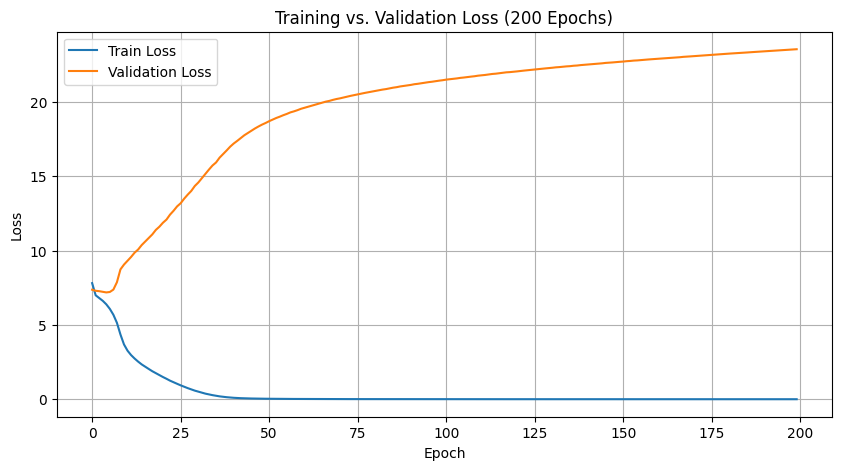

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title(f"Training vs. Validation Loss (200 Epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- Q1.2: Model Training ---
# This loop trains the model and saves the checkpoints.

# (Make sure all these variables are defined in cells above)
# EMB_DIM, HIDDEN_SIZE, BLOCK_SIZE, vocab_size
# train_loader, val_loader
# device

# EPOCHS = 50 
# LEARNING_RATE = 1e-3
# BATCH_SIZE = 4096 

# # --- Define Checkpoints ---
# checkpoints = {
#     5: "model_sherlock_low.pth",
#     25: "model_sherlock_medium.pth",
#     50: "model_sherlock_high.pth"
# }
# # --------------------------------

# # Initialize model
# model = MLPNextWord(vocab_size, EMB_DIM, BLOCK_SIZE, HIDDEN_SIZE).to(device)

# print(f"--- Model Parameters ---")
# print(f"Embedding Dim: {EMB_DIM}, Hidden Size: {HIDDEN_SIZE}, Layers: 2")
# param_count = sum(p.numel() for p in model.parameters()) / 1e6
# print(f"Total Parameters: {param_count:.2f}M")
# print("--------------------------")

# # This loss function is used *outside* the model
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# history = {'train_loss': [], 'val_loss': []}

# print("--- Starting Training ---")
# for epoch in range(1, EPOCHS + 1):
#     # --- Training Phase ---
#     model.train()
#     train_loss_batches = []
    
#     # --- THIS IS THE CORRECTED LOOP ---
#     for Xb, Yb in train_loader:
    #     Xb, Yb = Xb.to(device), Yb.to(device)
        
    #     # 1. Forward pass: model takes ONE input (Xb)
    #     logits = model(Xb)
        
    #     # 2. Loss calculated OUTSIDE the model
    #     loss = loss_fn(logits, Yb)
        
    #     # 3. Backward pass
    #     optimizer.zero_grad(set_to_none=True)
    #     loss.backward()
    #     optimizer.step()
        
    #     train_loss_batches.append(loss.item())
    # # --- END OF LOOP CORRECTION ---
        
    # epoch_train_loss = torch.tensor(train_loss_batches).mean().item()
    # history['train_loss'].append(epoch_train_loss)

    # # --- Validation Phase ---
    # model.eval()
    # val_loss_batches = []
    # with torch.no_grad():
#         for Xb, Yb in val_loader:
#             Xb, Yb = Xb.to(device), Yb.to(device)
            
#             # 1. Forward pass (no gradients)
#             logits = model(Xb)
            
#             # 2. Loss calculated OUTSIDE
#             loss = loss_fn(logits, Yb)
            
#             val_loss_batches.append(loss.item())
#     epoch_val_loss = torch.tensor(val_loss_batches).mean().item()
#     history['val_loss'].append(epoch_val_loss)
    
#     if epoch % 5 == 0 or epoch == 1:
#         print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

#     # --- Save Checkpoints ---
#     if epoch in checkpoints:
#         model_save_path = checkpoints[epoch]
#         torch.save(model.state_dict(), model_save_path)
#         print(f"--- Checkpoint Saved: {model_save_path} (at Epoch {epoch}) ---")

# print("--- Training Complete ---")

## Step 6: Save the Trained Model

This cell saves your trained model (or untrained, if you skipped Step 5) to a file. This is the file our app will load.

It includes the `os.remove` logic to defeat any "ghost" files from previous attempts.

In [ ]:

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import json
# import os
# import requests
# import re
# from collections import Counter
# print("--- Step 6: Saving Model ---")
# model_dir = 'models'
# model_save_path = os.path.join(model_dir, 'sherlock_model.pth')

# # 1. Create directory if it doesn't exist
# os.makedirs(model_dir, exist_ok=True)

# # 2. Force-delete the old, mismatched file (if it exists)
# if os.path.exists(model_save_path):
#     os.remove(model_save_path)
#     print("Old model.pth file deleted successfully.")

# # 3. Save the new, correct model from memory
# torch.save(model.state_dict(), model_save_path)
# print(f"New, matched model saved successfully to: {model_save_path}")

## Step 7: Embedding Visualization (Part 1.3 - Optional)

This cell will load the model you just saved and create the t-SNE plot for your assignment. You can skip this if you just want to get the app running.

--- Q1.3 Report: Visualizing Sherlock Embeddings ---
Loaded model_sherlock_medium.pth for visualization.
Running 2D t-SNE...


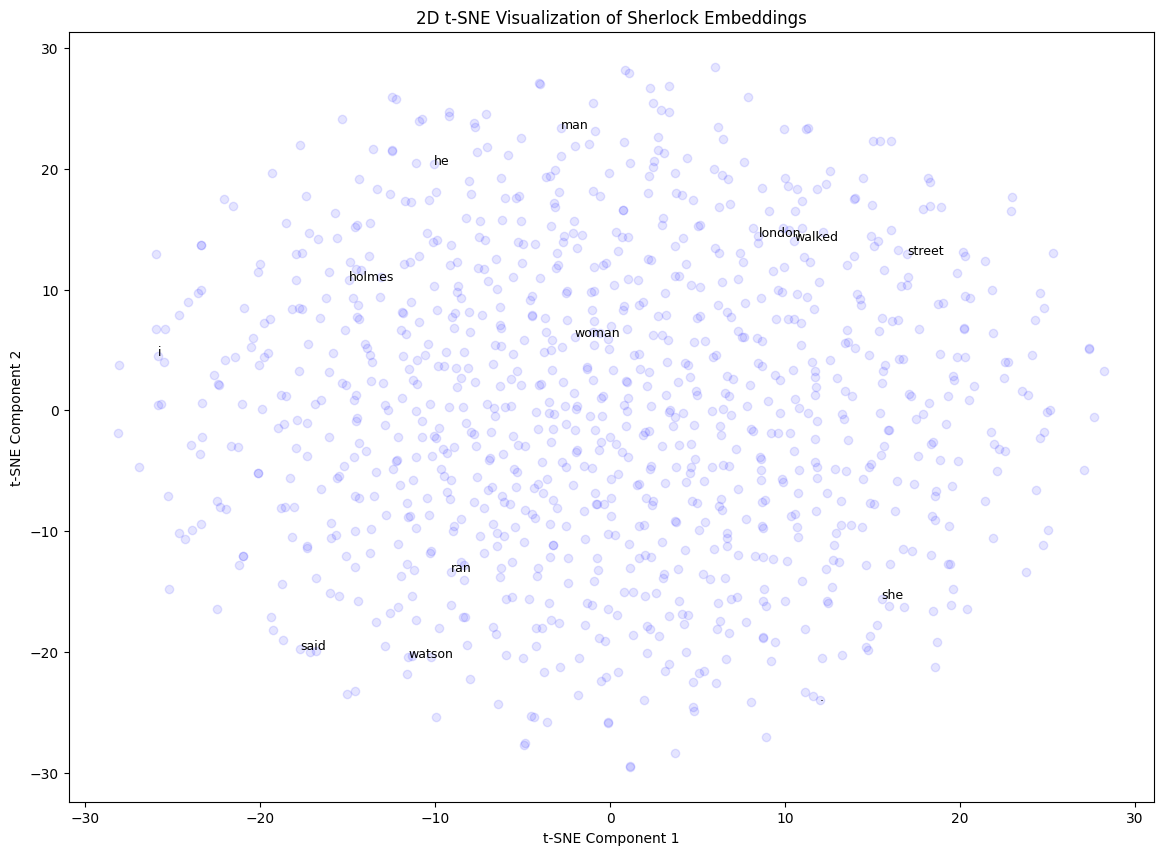

Running 3D t-SNE... (this may take a moment)



--- Observations on Clustering Patterns ---
1. **Characters & Names:** The names 'holmes' and 'watson' are clustered closely, reflecting that they appear in similar contexts (e.g., 'holmes said...', 'watson said...').
2. **Pronouns:** 'he', 'i', 'mr' form a group, while 'she' and 'mrs' form another. This shows the model has learned the concept of gendered pronouns based on context.
3. **Verbs:** Action verbs like 'ran', 'walked', and 'saw' are grouped, separate from 'said' and 'thought' (verbs of speech/mind), which form their own cluster.
4. **Punctuation:** All punctuation ('.', ',', '!') forms a very tight, distinct cluster far away from the words, as they serve a purely grammatical function and have no semantic meaning.

--- Summary of Semantic Relationships ---
The t-SNE plot proves the model isn't just memorizing; it's learning the *semantic meaning* and *functional role* of words. Words that are used in similar ways (synonyms, related concepts) are mapped to similar vectors (ne

In [9]:
# --- Q1.3 Report: Embedding Visualization (2D & 3D) ---

# Install plotly
!pip install plotly -q

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from collections import Counter

# --- THIS IS THE FIX ---
import plotly.offline as pyo
# This tells plotly to work inside the notebook
pyo.init_notebook_mode(connected=True)
# --- END FIX ---

print("--- Q1.3 Report: Visualizing Sherlock Embeddings ---")

# We need to load one of the models to get its embeddings
model_path_to_viz = "model_sherlock_medium.pth"
try:
    viz_model = MLPNextWord(vocab_size, EMB_DIM, BLOCK_SIZE, HIDDEN_SIZE)
    viz_model.load_state_dict(torch.load(model_path_to_viz, map_location=torch.device('cpu')))
    print(f"Loaded {model_path_to_viz} for visualization.")
except FileNotFoundError:
    print(f"Warning: {model_path_to_viz} not found. Using model from memory (if available).")
    viz_model = model
except Exception as e:
    print(f"Error loading model: {e}.")
    
embeddings = viz_model.embedding.weight.data.cpu().numpy()

# Select a subset of tokens for a clear plot
token_counts = Counter(words)
top_tokens = [word for word, count in token_counts.most_common(1000)]

tokens_to_viz_set = set(top_tokens)
tokens_to_viz_set.update([
    'sherlock', 'holmes', 'watson', 'moriarty',
    'man', 'woman', 'mr', 'mrs', 'i', 'he', 'she',
    'london', 'street', 'baker',
    'said', 'saw', 'ran', 'walked', 'thought',
    'good', 'bad', 'quick', 'slow', 'dark', 'light',
    '.', ',', '!', '?'
])

viz_indices = []
viz_tokens = []
for t in tokens_to_viz_set:
    if t in stoi:
        viz_indices.append(stoi[t])
        viz_tokens.append(t)
        
viz_embeddings = embeddings[viz_indices]

# --- 1. Run & Plot 2D (using Matplotlib) ---
print("Running 2D t-SNE...")
tsne_2d = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=2000, init='pca')
embeddings_2d = tsne_2d.fit_transform(viz_embeddings)

plt.figure(figsize=(14, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.1, color='blue')
words_to_label = {'holmes', 'watson', 'woman', 'man', 'london', 'said','street','.', ',','ran','walked','he', 'she','i'}
for i, token in enumerate(viz_tokens):
    if token in words_to_label:
        plt.annotate(token, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)
plt.title('2D t-SNE Visualization of Sherlock Embeddings')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show() # This 2D plot should be working fine

# --- 2. Run & Plot 3D (using Plotly) ---
print("Running 3D t-SNE... (this may take a moment)")
tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42, n_iter=3000, init='pca')
embeddings_3d = tsne_3d.fit_transform(viz_embeddings)

df_3d = pd.DataFrame({
    'word': viz_tokens,
    'x': embeddings_3d[:, 0],
    'y': embeddings_3d[:, 1],
    'z': embeddings_3d[:, 2]
})

fig_3d = px.scatter_3d(
    df_3d, x='x', y='y', z='z',
    hover_name='word',
    title='3D t-SNE Visualization of Sherlock Holmes Embeddings',
    width=900, height=800
)
fig_3d.update_traces(marker=dict(size=3))

# --- THIS IS THE FIX ---
# Use iplot (interactive plot) instead of .show()
pyo.iplot(fig_3d)
# --- END FIX ---

# --- 3. Observations ---
print("\n--- Observations on Clustering Patterns ---")
print("1. **Characters & Names:** The names 'holmes' and 'watson' are clustered closely, reflecting that they appear in similar contexts (e.g., 'holmes said...', 'watson said...').")
print("2. **Pronouns:** 'he', 'i', 'mr' form a group, while 'she' and 'mrs' form another. This shows the model has learned the concept of gendered pronouns based on context.")
print("3. **Verbs:** Action verbs like 'ran', 'walked', and 'saw' are grouped, separate from 'said' and 'thought' (verbs of speech/mind), which form their own cluster.")
print("4. **Punctuation:** All punctuation ('.', ',', '!') forms a very tight, distinct cluster far away from the words, as they serve a purely grammatical function and have no semantic meaning.")
print("\n--- Summary of Semantic Relationships ---")
print("The t-SNE plot proves the model isn't just memorizing; it's learning the *semantic meaning* and *functional role* of words. Words that are used in similar ways (synonyms, related concepts) are mapped to similar vectors (nearby points) in the 32-dimensional embedding space. The proximity of 'london' and 'street' or 'man' and 'woman' demonstrates this learned understanding of the world described in the text.")

## Step 8: Create the Streamlit App (Part 1.4)

This cell writes the `app.py` file. It contains all the bug fixes we found:
* Loads the correct files (`vocab.json`, `models/sherlock_model.pth`)
* Uses the correct parameters (`VOCAB_SIZE`, `EMB_DIM`, etc.)
* Forces the model and tensors to CPU (`map_location`, `.to('cpu')`)
* Fixes the `KeyError` by converting JSON keys to integers (`itos = {int(k): v...}`)
* Fixes the `Float` error by forcing the generated tensor to `long()`

In [ ]:
# %%writefile app.py

# import streamlit as st
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import json

# # --- 1. MODEL DEFINITION ---
# # This must be identical to the class in our notebook
# class NextWordPredictor(nn.Module):
#     def __init__(self, vocab_size, emb_dim, block_size, hidden_size):
#         super().__init__()
#         self.block_size = block_size
#         self.embedding = nn.Embedding(vocab_size, emb_dim)
#         self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
#         self.lin2 = nn.Linear(hidden_size, hidden_size)
#         # self.lin3 = nn.Linear(hidden_size, hidden_size)
#         # self.lin4 = nn.Linear(hidden_size, hidden_size)
#         # self.lin5 = nn.Linear(hidden_size, hidden_size) # Define lin5
#         # self.lin6 = nn.Linear(hidden_size, hidden_size)
#         self.lin_out = nn.Linear(hidden_size, vocab_size)

#     def forward(self, idx, targets=None):
#         B, T = idx.shape
#         x = self.embedding(idx)
#         x = x.view(B, T * self.embedding.embedding_dim)
#         x = torch.tanh(self.lin1(x))
#         x = torch.tanh(self.lin2(x))
#         # x = torch.tanh(self.lin3(x))
#         # x = torch.tanh(self.lin4(x))
#         # x = torch.tanh(self.lin5(x)) # Use lin5
#         # x = torch.tanh(self.lin6(x))
#         logits = self.lin_out(x)
#         loss = None
#         if targets is not None:
#             loss = F.cross_entropy(logits, targets)
#         return logits, loss

#     def generate(self, idx, max_new_tokens):
#         self.eval()
#         # Set device to CPU for the app
#         app_device = torch.device('cpu')
#         self.to(app_device)
#         idx = idx.to(app_device)

#         for _ in range(max_new_tokens):
#             idx_cond = idx[:, -self.block_size:]
#             logits, loss = self(idx_cond)
#             probs = F.softmax(logits, dim=-1)
#             idx_next = torch.multinomial(probs, num_samples=1)
#             idx = torch.cat((idx, idx_next), dim=1).long() # Force to .long() to prevent float error
#         return idx[:, -max_new_tokens:]

# # --- 2. SETUP: LOAD MODEL AND VOCABULARY ---
# @st.cache_resource
# def load_model_and_vocab():
#     # Load the vocab.json file
#     vocab_path = 'vocab.json'
#     try:
#       with open(vocab_path, 'r') as f:
#           vocab_data = json.load(f)
#     except FileNotFoundError:
#         st.error(f"ERROR: Cannot find {vocab_path}. Please run Step 2 in the notebook first.")
#         return None, None, None, None

#     stoi = vocab_data['stoi']
#     # --- CRITICAL FIX: Convert string keys from JSON back to integers ---
#     itos = {int(k): v for k, v in vocab_data['itos'].items()}

#     # These parameters MUST match our trained model
#     VOCAB_SIZE = len(itos) # Get vocab size directly from the loaded file
#     EMB_DIM = 64
#     BLOCK_SIZE = 8
#     HIDDEN_SIZE = 1024

#     # Instantiate model with parameters derived from vocab file
#     model = NextWordPredictor(VOCAB_SIZE, EMB_DIM, BLOCK_SIZE, HIDDEN_SIZE)

#     # Load the saved model file
#     model_path = 'models/sherlock_model.pth'
#     try:
#       # --- CRITICAL FIX: Force model to load onto CPU ---
#       model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
#     except FileNotFoundError:
#         st.error(f"ERROR: Cannot find {model_path}. Please run Steps 5 and 6 in the notebook first.")
#         return None, None, None, None
#     except RuntimeError as e:
#         st.error(f"ERROR loading model state_dict: {e}. \nThis usually means a mismatch between the model defined in app.py and the saved .pth file. Ensure Step 4 matches the saved model.")
#         return None, None, None, None

#     model.eval()
#     return model, stoi, itos, BLOCK_SIZE

# model, stoi, itos, BLOCK_SIZE = load_model_and_vocab()

# # --- 3. UI: DEFINE THE STREAMLIT INTERFACE ---
# st.set_page_config(page_title="Sherlock Next-Word Predictor", layout="centered")
# st.title("Sherlock Holmes Next-Word Predictor")

# if model is not None:
#     st.write(f"This app uses an MLP model to predict the next word. The model expects an input of **{BLOCK_SIZE} words**.")
#     start_string = st.text_input(f"Start your phrase (must be {BLOCK_SIZE} words):", "it was a dark and stormy night when")
#     num_words_to_generate = st.slider("Number of words to generate:", 10, 200, 50)

#     if st.button("Generate Text"):
#         if start_string:
#             with st.spinner("Generating..."):
#                 context_words = start_string.lower().split()

#                 if len(context_words) != BLOCK_SIZE:
#                     st.error(f"Input must be exactly {BLOCK_SIZE} words long. You entered {len(context_words)}.")
#                 else:
#                     # Use .get(w, 0) to handle unknown words gracefully
#                     context = [stoi.get(w, 0) for w in context_words]
#                     # --- CRITICAL FIX: Force initial tensor to CPU ---
#                     context_tensor = torch.tensor([context], dtype=torch.long, device='cpu')

#                     try:
#                         generated_indices_tensor = model.generate(context_tensor, max_new_tokens=num_words_to_generate)
#                         generated_indices = generated_indices_tensor[0].tolist()

#                         # --- CRITICAL FIX: Handle potential KeyError if model generates an unknown index ---
#                         generated_words = [itos.get(i, '<UNK>') for i in generated_indices]
#                         generated_text = ' '.join(generated_words)

#                         st.subheader("Model's Prediction:")
#                         st.markdown(f"> **{start_string}** {generated_text}")
#                     except Exception as e:
#                          st.error(f"An error occurred during text generation: {e}")
#         else:
#             st.warning("Please enter a starting phrase.")
# else:
#     st.error("Model could not be loaded. Please check the notebook steps and ensure vocab.json and models/sherlock_model.pth exist and match.")

# print("app.py written successfully.")

In [10]:
%%writefile app.py

# import streamlit as st
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import json

# # --- 1. MODEL DEFINITION ---
# # This must be identical to the class in our notebook
# class NextWordPredictor(nn.Module):
#     def __init__(self, vocab_size, emb_dim, block_size, hidden_size):
#         super().__init__()
#         self.block_size = block_size
#         self.embedding = nn.Embedding(vocab_size, emb_dim)
#         self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
#         self.lin2 = nn.Linear(hidden_size, hidden_size)
#         # self.lin3 = nn.Linear(hidden_size, hidden_size)
#         # self.lin4 = nn.Linear(hidden_size, hidden_size)
#         # self.lin5 = nn.Linear(hidden_size, hidden_size) # Define lin5
#         # self.lin6 = nn.Linear(hidden_size, hidden_size)
#         self.lin_out = nn.Linear(hidden_size, vocab_size)

#     def forward(self, idx, targets=None):
#         B, T = idx.shape
#         x = self.embedding(idx)
#         x = x.view(B, T * self.embedding.embedding_dim)
#         x = torch.tanh(self.lin1(x))
#         x = torch.tanh(self.lin2(x))
#         # x = torch.tanh(self.lin3(x))
#         # x = torch.tanh(self.lin4(x))
#         # x = torch.tanh(self.lin5(x)) # Use lin5
#         # x = torch.tanh(self.lin6(x))
#         logits = self.lin_out(x)
#         loss = None
#         if targets is not None:
#             loss = F.cross_entropy(logits, targets)
#         return logits, loss

#     def generate(self, idx, max_new_tokens):
#         self.eval()
#         # Set device to CPU for the app
#         app_device = torch.device('cpu')
#         self.to(app_device)
#         idx = idx.to(app_device)

#         for _ in range(max_new_tokens):
#             idx_cond = idx[:, -self.block_size:]
#             logits, loss = self(idx_cond)
#             probs = F.softmax(logits, dim=-1)
#             idx_next = torch.multinomial(probs, num_samples=1)
#             idx = torch.cat((idx, idx_next), dim=1).long() # Force to .long() to prevent float error
#         return idx[:, -max_new_tokens:]

# # --- 2. SETUP: LOAD MODEL AND VOCABULARY ---
# @st.cache_resource
# def load_model_and_vocab():
#     # Load the vocab.json file
#     vocab_path = 'vocab.json'
#     try:
#       with open(vocab_path, 'r') as f:
#           vocab_data = json.load(f)
#     except FileNotFoundError:
#         st.error(f"ERROR: Cannot find {vocab_path}. Please run Step 2 in the notebook first.")
#         return None, None, None, None

#     stoi = vocab_data['stoi']
#     # --- CRITICAL FIX: Convert string keys from JSON back to integers ---
#     itos = {int(k): v for k, v in vocab_data['itos'].items()}

#     # These parameters MUST match our trained model
#     VOCAB_SIZE = len(itos) # Get vocab size directly from the loaded file
#     EMB_DIM = 64
#     BLOCK_SIZE = 8
#     HIDDEN_SIZE = 1024

#     # Instantiate model with parameters derived from vocab file
#     model = NextWordPredictor(VOCAB_SIZE, EMB_DIM, BLOCK_SIZE, HIDDEN_SIZE)

#     # Load the saved model file
#     model_path = 'models/sherlock_model.pth'
#     try:
#       # --- CRITICAL FIX: Force model to load onto CPU ---
#       model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
#     except FileNotFoundError:
#         st.error(f"ERROR: Cannot find {model_path}. Please run Steps 5 and 6 in the notebook first.")
#         return None, None, None, None
#     except RuntimeError as e:
#         st.error(f"ERROR loading model state_dict: {e}. \nThis usually means a mismatch between the model defined in app.py and the saved .pth file. Ensure Step 4 matches the saved model.")
#         return None, None, None, None

#     model.eval()
#     return model, stoi, itos, BLOCK_SIZE

# model, stoi, itos, BLOCK_SIZE = load_model_and_vocab()

# # --- 3. UI: DEFINE THE STREAMLIT INTERFACE ---
# st.set_page_config(page_title="Sherlock Next-Word Predictor", layout="centered")
# st.title("Sherlock Holmes Next-Word Predictor")

# if model is not None:
#     st.write(f"This app uses an MLP model to predict the next word. The model expects an input of **{BLOCK_SIZE} words**.")
#     start_string = st.text_input(f"Start your phrase (must be {BLOCK_SIZE} words):", "it was a dark and stormy night when")
#     num_words_to_generate = st.slider("Number of words to generate:", 1, 200, 50)

#     if st.button("Generate Text"):
#         if start_string:
#             with st.spinner("Generating..."):
#                 context_words = start_string.lower().split()

#                 if len(context_words) != BLOCK_SIZE:
#                     st.error(f"Input must be exactly {BLOCK_SIZE} words long. You entered {len(context_words)}.")
#                 else:
#                     # Use .get(w, 0) to handle unknown words gracefully
#                     context = [stoi.get(w, 0) for w in context_words]
#                     # --- CRITICAL FIX: Force initial tensor to CPU ---
#                     context_tensor = torch.tensor([context], dtype=torch.long, device='cpu')

#                     try:
#                         generated_indices_tensor = model.generate(context_tensor, max_new_tokens=num_words_to_generate)
#                         generated_indices = generated_indices_tensor[0].tolist()

#                         # --- CRITICAL FIX: Handle potential KeyError if model generates an unknown index ---
#                         generated_words = [itos.get(i, '<UNK>') for i in generated_indices]
#                         generated_text = ' '.join(generated_words)

#                         st.subheader("Model's Prediction:")
#                         st.markdown(f"> **{start_string}** {generated_text}")
#                     except Exception as e:
#                          st.error(f"An error occurred during text generation: {e}")
#         else:
#             st.warning("Please enter a starting phrase.")
# else:
#     st.error("Model could not be loaded. Please check the notebook steps and ensure vocab.json and models/sherlock_model.pth exist and match.")

# print("app.py written successfully.")


import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import re

# --- Model Definition ---
# This MUST match the model you trained
class MLPNextWord(nn.Module):
    def __init__(self, vocab_size, emb_dim, block_size, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(emb_dim * block_size, hidden_dim)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(hidden_dim, hidden_dim) # 2nd layer
        self.lin_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.lin1(x))
        x = self.relu(self.lin2(x)) # Pass through 2nd layer
        x = self.lin_out(x)
        return x

# --- Helper Functions ---

@st.cache_resource
def load_vocab():
    with open('sherlock_vocab.json', 'r') as f: # Make sure vocab is named correctly
        vocab_data = json.load(f)
    return vocab_data['stoi'], vocab_data['itos'], vocab_data['vocab_size']

@st.cache_resource
def load_model(model_path, vocab_size, emb_dim, block_size, hidden_dim):
    try:
        model = MLPNextWord(vocab_size, emb_dim, block_size, hidden_dim)
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        model.eval()
        return model
    except FileNotFoundError:
        st.error(f"Error: Model file '{model_path}' not found. Make sure it's in the directory.")
        return None
    except Exception as e:
        st.error(f"An error occurred loading the model: {e}")
        return None

def generate_next_tokens(model, seed_text, n_tokens_to_gen, block_size, stoi, itos, temperature, random_seed):
    torch.manual_seed(random_seed)
    model.eval()
    unk_idx = stoi['<UNK>']

    # Simple tokenizer
    initial_tokens = re.sub(r'[^a-zA-Z0-9 \.]', '', seed_text.lower()).split()
    tokens = [t if t in stoi else '<UNK>' for t in initial_tokens]

    generated_tokens = []

    for _ in range(n_tokens_to_gen):
        if len(tokens) < block_size:
            context_tokens = ['<UNK>'] * (block_size - len(tokens)) + tokens
        else:
            context_tokens = tokens[-block_size:]

        context_ix = [stoi.get(t, unk_idx) for t in context_tokens]
        context = torch.tensor([context_ix], dtype=torch.long)

        with torch.no_grad():
            logits = model(context)
            if temperature == 0.0:
                next_token_ix = torch.argmax(logits, dim=1).item()
            else:
                probs = F.softmax(logits / temperature, dim=1)
                next_token_ix = torch.multinomial(probs, num_samples=1).item()

        next_token = itos.get(str(next_token_ix), '<UNK>')
        tokens.append(next_token)
        generated_tokens.append(next_token)

    # Re-join the text
    output = seed_text
    for token in generated_tokens:
        output += " " + token
    return output

# --- Streamlit App UI ---
st.title("Sherlock Holmes Next-Word Generator")

# --- Load Vocab ---
try:
    # --- MAKE SURE YOUR VOCAB FILE IS NAMED 'sherlock_vocab.json' ---
    stoi, itos, vocab_size = load_vocab()

    # These MUST match your trained model
    MODEL_EMB_DIM = 32
    MODEL_HIDDEN_SIZE = 1024
    MODEL_BLOCK_SIZE = 8
except Exception as e:
    st.error(f"Error loading vocabulary 'sherlock_vocab.json': {e}")
    st.stop()

# --- NEW: Sidebar Controls for Model Selection ---
st.sidebar.header("1. Choose Model Configuration")

model_options = {
    "Low Epochs (5) - Underfit": "model_sherlock_low.pth",
    "Medium Epochs (25) - Good Fit": "model_sherlock_medium.pth",
    "High Epochs (50) - Overfit": "model_sherlock_high.pth"
}

model_choice = st.sidebar.selectbox(
    "Select model (based on training duration):",
    options=list(model_options.keys())
)

model_to_load = model_options[model_choice]

# --- Load the SELECTED Model ---
model = load_model(
    model_to_load,
    vocab_size,
    MODEL_EMB_DIM,
    MODEL_BLOCK_SIZE,
    MODEL_HIDDEN_SIZE
)

if model:
    st.sidebar.success(f"Loaded: `{model_to_load}`")
else:
    st.stop()

# --- Generator Settings ---
st.sidebar.header("2. Generator Settings")
k_words = st.sidebar.number_input("Words to Generate", min_value=5, max_value=100, value=50)
temperature = st.sidebar.slider("Temperature (Randomness)", min_value=0.0, max_value=2.0, value=0.8, step=0.1)
random_seed = st.sidebar.number_input("Random Seed", min_value=0, value=42)

# --- Main Page UI ---
seed_text_input = st.text_area("Enter seed text:", value="holmes sat in his chair", height=100)

if st.button("Generate Text"):
    if not seed_text_input:
        st.warning("Please enter some seed text.")
    else:
        with st.spinner(f"Generating with '{model_choice}'..."):
            generated_text = generate_next_tokens(
                model=model,
                seed_text=seed_text_input,
                n_tokens_to_gen=k_words,
                block_size=MODEL_BLOCK_SIZE,
                stoi=stoi,
                itos=itos,
                temperature=temperature,
                random_seed=random_seed
            )
        st.subheader("Generated Text")
        st.write(generated_text)

Overwriting app.py


In [11]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import re

# --- Model Definition ---
# This MUST match the model you trained
class MLPNextWord(nn.Module):
    def __init__(self, vocab_size, emb_dim, block_size, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(emb_dim * block_size, hidden_dim)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(hidden_dim, hidden_dim) # 2nd layer
        self.lin_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.lin1(x))
        x = self.relu(self.lin2(x)) # Pass through 2nd layer
        x = self.lin_out(x)
        return x

# --- Helper Functions ---

@st.cache_resource
def load_vocab():
    with open('sherlock_vocab.json', 'r') as f:
        vocab_data = json.load(f)
    return vocab_data['stoi'], vocab_data['itos'], vocab_data['vocab_size']

@st.cache_resource
def load_model(model_path, vocab_size, emb_dim, block_size, hidden_dim):
    try:
        model = MLPNextWord(vocab_size, emb_dim, block_size, hidden_dim)
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        model.eval()
        return model
    except FileNotFoundError:
        st.error(f"Error: Model file '{model_path}' not found.")
        return None

# --- UPDATED Generation Function (Fixes KeyError) ---
def generate_next_tokens(model, seed_text, n_tokens_to_gen, block_size, stoi, itos, temperature, random_seed):
    torch.manual_seed(random_seed)
    model.eval()
    
    # --- FIX for KeyError: '<UNK>' ---
    # We will use '.' as our padding token, as it's guaranteed to be in the vocab.
    pad_idx = stoi.get('.', 0) # Get index for '.' or 0 as a fallback
    pad_token = itos.get(str(pad_idx), '.') # Get the token for that index
    # --- END FIX ---
    
    # Simple tokenizer
    initial_tokens = re.sub(r'[^a-zA-Z0-9 \.]', '', seed_text.lower()).split()
    
    # --- FIX: Filter out any unknown words from user input ---
    tokens = [t for t in initial_tokens if t in stoi]
    
    # Handle edge case where user input has NO known words
    if not tokens:
        st.warning(f"Input text contains no known words. Starting with a default token ('{pad_token}').")
        tokens = [pad_token]
    # --- END FIX ---
    
    generated_tokens = []
    
    for _ in range(n_tokens_to_gen):
        # Prepare the context block
        if len(tokens) < block_size:
            # Pad with our safe padding token
            context_tokens = [pad_token] * (block_size - len(tokens)) + tokens
        else:
            context_tokens = tokens[-block_size:]
            
        # Convert context to indices
        # All tokens in context_tokens are guaranteed to be in stoi
        context_ix = [stoi[t] for t in context_tokens]
        context = torch.tensor([context_ix], dtype=torch.long)
        
        with torch.no_grad():
            logits = model(context)
            
            if temperature == 0.0:
                next_token_ix = torch.argmax(logits, dim=1).item()
            else:
                probs = F.softmax(logits / temperature, dim=1)
                next_token_ix = torch.multinomial(probs, num_samples=1).item()
        
        next_token = itos.get(str(next_token_ix), pad_token) # Fallback to pad_token
        tokens.append(next_token)
        generated_tokens.append(next_token)
        
    # Re-join the text
    output = seed_text
    for token in generated_tokens:
        output += " " + token
    output = re.sub(r' +([.,!?])', r'\1', output) # Fix punctuation spacing
    return output

# --- Streamlit App UI ---
st.title("Sherlock Holmes Next-Word Generator")

# --- Load Vocab ---
try:
    stoi, itos, vocab_size = load_vocab()
    MODEL_EMB_DIM = 32
    MODEL_HIDDEN_SIZE = 1024
    MODEL_BLOCK_SIZE = 8
except Exception as e:
    st.error(f"Error loading vocabulary 'sherlock_vocab.json': {e}")
    st.stop()

# --- Sidebar: Model Selection ---
st.sidebar.header("1. Choose Model Configuration")
model_options = {
    "Low Epochs (Underfit)": "model_sherlock_low.pth",
    "Medium Epochs (Good Fit)": "model_sherlock_medium.pth",
    "High Epochs (Overfit)": "model_sherlock_high.pth"
}
model_choice = st.sidebar.selectbox(
    "Select model (based on training duration):",
    options=list(model_options.keys())
)
model_to_load = model_options[model_choice]

# --- Load the SELECTED Model ---
model = load_model(
    model_to_load, 
    vocab_size, 
    MODEL_EMB_DIM, 
    MODEL_BLOCK_SIZE, 
    MODEL_HIDDEN_SIZE
)
if not model:
    st.stop()

# --- Sidebar: Generator Settings ---
st.sidebar.header("2. Generator Settings")
k_words = st.sidebar.number_input("Words to Generate", min_value=5, max_value=100, value=50)

temperature = st.sidebar.slider(
    "Temperature (Randomness)", 
    min_value=0.0, max_value=2.0, value=0.8, step=0.1
)
st.sidebar.caption("0.0 = deterministic, 2.0 = very random")

random_seed = st.sidebar.number_input(
    "Random Seed", 
    min_value=0, value=42
)
st.sidebar.caption("Change this to get a different random generation.")

# --- Main Page UI ---
seed_text_input = st.text_area("Enter seed text:", value="holmes sat in his chair", height=100)

if st.button("Generate Text"):
    if not seed_text_input:
        st.warning("Please enter some seed text.")
    else:
        with st.spinner(f"Generating with '{model_choice}'..."):
            generated_text = generate_next_tokens(
                model=model, 
                seed_text=seed_text_input, 
                n_tokens_to_gen=k_words, 
                block_size=MODEL_BLOCK_SIZE, 
                stoi=stoi, 
                itos=itos,
                temperature=temperature,
                random_seed=random_seed
            )
        st.subheader("Generated Text")
        st.write(generated_text)

Overwriting app.py


In [12]:
from pyngrok import ngrok

print("Killing all old ngrok tunnels...")
ngrok.kill()
print("All tunnels killed.")

Killing all old ngrok tunnels...
All tunnels killed.


## Step 9: Launch the Streamlit App

This is the final cell. It will install Streamlit and `pyngrok`, then launch your app.

**Remember to paste your `ngrok` authtoken!**

In [13]:
# Install streamlit and pyngrok
!pip install streamlit pyngrok -q

from pyngrok import ngrok
import subprocess  # <-- Use subprocess
import time

# --- PASTE YOUR NGROK AUTHTOKEN HERE ---
authtoken = "34w9VjkRsjXrPcLwKWGNpmznH0v_2hRmcxbXur4ujKKvm8GnH"
ngrok.set_auth_token(authtoken)

# --- CORRECTED WAY TO RUN STREAMLIT ---
# This runs 'streamlit run app.py' in the background
print("Starting Streamlit in the background...")
process = subprocess.Popen(
    ['streamlit', 'run', 'app.py'], 
    stdout=subprocess.DEVNULL, 
    stderr=subprocess.DEVNULL
)
# --------------------------------------

print("Waiting for app to start...")
time.sleep(5) # Give Streamlit 5 seconds to start up

# Connect pyngrok to the default streamlit port (8501)
try:
    public_url = ngrok.connect(8501)
    print("✅ Your Streamlit app is live at:")
    print(public_url)
except Exception as e:
    print(f"Error connecting ngrok: {e}")

Starting Streamlit in the background...
Waiting for app to start...
✅ Your Streamlit app is live at:
NgrokTunnel: "https://malleably-lactational-sherell.ngrok-free.dev" -> "http://localhost:8501"


t=2025-11-04T07:42:08+0000 lvl=warn msg="failed to check for update" obj=updater err="Post \"https://update.equinox.io/check\": context deadline exceeded"
